In [ ]:
import torch
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('Bummer!  Training on CPU ...')
else:
    print('You are good to go!  Training on GPU ...')

You are good to go!  Training on GPU ...


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
!wget --no-check-certificate \
    -r 'https://docs.google.com/uc?export=download&id=16XvPBgm0_ImeB3TmudnV0c2JTMc074wK' \
    -O /content/dataset_gray_split.zip

will be placed in the single file you specified.

--2021-11-29 08:56:40--  https://docs.google.com/uc?export=download&id=16XvPBgm0_ImeB3TmudnV0c2JTMc074wK
Resolving docs.google.com (docs.google.com)... 108.177.121.102, 108.177.121.139, 108.177.121.101, ...
Connecting to docs.google.com (docs.google.com)|108.177.121.102|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0k-9s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/75vmmd81tu60poupipaeag64nbsp7q68/1638176175000/05754306046710977403/*/16XvPBgm0_ImeB3TmudnV0c2JTMc074wK?e=download [following]
--2021-11-29 08:56:51--  https://doc-0k-9s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/75vmmd81tu60poupipaeag64nbsp7q68/1638176175000/05754306046710977403/*/16XvPBgm0_ImeB3TmudnV0c2JTMc074wK?e=download
Resolving doc-0k-9s-docs.googleusercontent.com (doc-0k-9s-docs.googleusercontent.com)... 108.177.120.132, 2607:f8b0:4001:c18::84
Connecti

In [ ]:
import os
import zipfile

local_zip = '/content/dataset_gray_split.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [ ]:


# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'dataset_gray_split/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


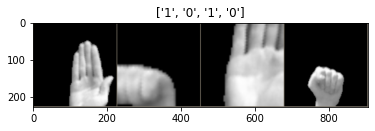

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    loss_list = {}
    loss_list['train'] = []
    loss_list['test'] = []

    accuracy_list = {}
    accuracy_list['train'] = []
    accuracy_list['test'] = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            loss_list[phase].append(epoch_loss)
            accuracy_list[phase].append(epoch_acc.item())

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best test Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, loss_list, accuracy_list

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('real: {} predicted: {}'.format(labels[j],class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
model_ft = models.vgg16(pretrained=True)
#model_vgg.classifer[6]=nn.Linear(4096,52)
num_ftrs = model_ft.classifier[6].in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.classifier[6] = nn.Linear(num_ftrs, 10)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
epochs = 15
model_ft, loss_resnet, accuracy_resnet = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=epochs)

Epoch 0/14
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.7898 Acc: 0.7266
test Loss: 0.0092 Acc: 0.9978

Epoch 1/14
----------
train Loss: 0.3739 Acc: 0.8675
test Loss: 0.0043 Acc: 0.9993

Epoch 2/14
----------
train Loss: 0.3219 Acc: 0.8811
test Loss: 0.0033 Acc: 1.0000

Epoch 3/14
----------
train Loss: 0.2812 Acc: 0.9006
test Loss: 0.0010 Acc: 1.0000

Epoch 4/14
----------
train Loss: 0.2609 Acc: 0.9030
test Loss: 0.0023 Acc: 1.0000

Epoch 5/14
----------
train Loss: 0.2534 Acc: 0.9110
test Loss: 0.0000 Acc: 1.0000

Epoch 6/14
----------
train Loss: 0.2616 Acc: 0.9058
test Loss: 0.0010 Acc: 1.0000

Epoch 7/14
----------
train Loss: 0.1966 Acc: 0.9253
test Loss: 0.0001 Acc: 1.0000

Epoch 8/14
----------
train Loss: 0.1816 Acc: 0.9296
test Loss: 0.0001 Acc: 1.0000

Epoch 9/14
----------
train Loss: 0.1652 Acc: 0.9376
test Loss: 0.0000 Acc: 1.0000

Epoch 10/14
----------
train Loss: 0.1765 Acc: 0.9357
test Loss: 0.0001 Acc: 1.0000

Epoch 11/14
----------
train Loss: 0.1556 Acc: 0.9392
test Loss: 0.0001 Acc: 1.0000

Epoch 12/14


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


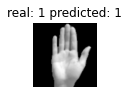

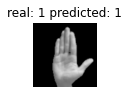

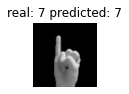

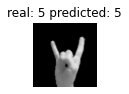

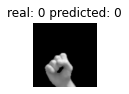

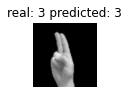

In [ ]:
visualize_model(model_ft)

In [ ]:
print(len(dataloaders['train'].dataset))

5381


In [ ]:
print(len(dataloaders['test'].dataset))

1346


In [ ]:
plt.plot(list(range(epochs)), accuracy_resnet["train"], marker=".", linestyle='--', label ="train")
plt.plot(list(range(epochs)), accuracy_resnet["test"], marker=".", linestyle='--', label ="test")
plt.title("Accuracy vs. epoch for VGG16")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc='best')

NameError: ignored

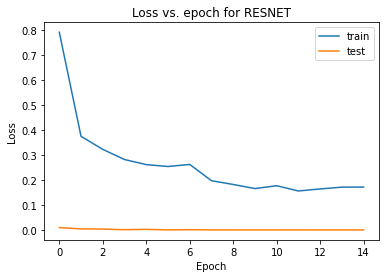

In [ ]:
plt.plot(list(range(epochs)), loss_resnet["train"], marker=".", linestyle='--', label ="train")
plt.plot(list(range(epochs)), loss_resnet["test"], marker=".", linestyle='--', label ="test")
plt.title("Loss vs. epoch for VGG16")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc='best')

In [ ]:
print(model_ft)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
loss_list = {}
loss_list['train'] = [0.7898,0.3739,0.3219, 0.2812, 0.2609, 0.2534, 0.2616, 0.1966, 0.1816, 0.1652, 0.1765, 0.1556, 0.1637, 0.1709, 0.1711]
loss_list['test'] = [0.0092,0.0043,0.0033,0.001,0.0023,0,0.001,0.0001,0.0001,0,0.0001,0.0001,0,0,0]


accuracy_list = {}
accuracy_list['train'] = [0.7266,0.8675,0.8811,0.9006,0.903,0.911,0.9058,0.9253,0.9296,0.9376,0.9357,0.9392,0.9407,0.9363,0.9383]
accuracy_list['test'] = [0.9978,0.9993,1,1,1,1,1,1,1,1,1,1,1,1,1]
epochs = 15

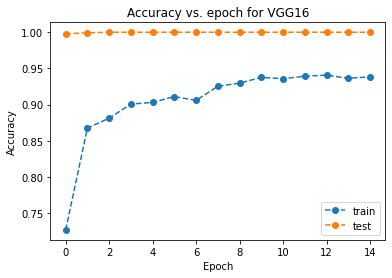

In [ ]:
plt.plot(list(range(epochs)), accuracy_list["train"], marker="o", linestyle='--', label ="train")
plt.plot(list(range(epochs)), accuracy_list["test"], marker="o", linestyle='--', label ="test")
plt.title("Accuracy vs. epoch for VGG16")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc='best')

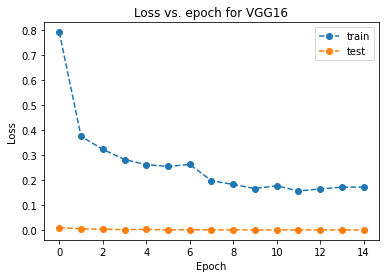

In [ ]:
plt.plot(list(range(epochs)), loss_list["train"], marker="o", linestyle='--', label ="train")
plt.plot(list(range(epochs)), loss_list["test"], marker="o", linestyle='--', label ="test")
plt.title("Loss vs. epoch for VGG16")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc='best')

In [ ]:
from prettytable import PrettyTable